In [1]:
using CSV, DataFrames
using Plots; gr();
using LsqFit
using Printf

$$
Corr(\tau) = Corr(n\Delta t) = \langle P_{control}(m\Delta t)\cdot P_{perturbed}(m\Delta t + n\Delta t)\rangle
$$

Where $\langle\cdot\rangle$ denotes Pearson correlation. 

$P$ is fluorescence polarization

In [2]:
function corr(n, X, Y)
    M = length(X)
    
    if n >= 0
        X_mean = sum(X[1:(end - n)])/(M - n)
        Y_mean = sum(Y[(n + 1):end])/(M - n)
        X1 = X[1:(end - n)] .- X_mean
        Y1 = Y[(n + 1):end] .- Y_mean
    else
        n = abs(n)
        X_mean = sum(X[(n + 1):end])/(M - n)
        Y_mean = sum(Y[1:(end - n)])/(M - n)
        X1 = X[(n + 1):end] .- X_mean
        Y1 = Y[1:(end - n)] .- Y_mean
    end
    
    r = X1'*Y1/sqrt(X1'*X1)/sqrt(Y1'*Y1)
end

corr (generic function with 1 method)

$$ \phi = CT/24*2\pi$$

In [3]:
# read
df = CSV.read("data/20240703_phi_to_Delta_phi_M25.csv", DataFrame)
rename!(df, ["Nr", "Time_h", "Time_s", "Temp", names(df)[5:end]...])

# ditch some columns
select!(df, Not([:Nr, :Time_s, :F17, :F18]))
    
# pivot longer
df_l = stack(df, Not([:Time_h, :Temp]), variable_name=:Position, value_name=:FP)

# parse plate position to treatments and circadian times
df_l[!, :Treatment] = (x -> x[1] == 'C' ? :Control : :Perturbed).(df_l[!, :Position])
well2CT = (x, offset) -> mod(24 - (x - offset)*4, 24)

df_l[!, :CT] = @. well2CT(parse(Int64, [x[2:end] for x in df_l.Position]), ifelse(df_l.Treatment == :Control, 3, 11))

select!(df_l, Not([:Position]))
df_l

Row,Time_h,Temp,FP,Treatment,CT
,Float64,Float64,Int64,Symbol,Int64
1,0.0,30.0,164,Control,0
2,0.250056,30.0,157,Control,0
3,0.500056,30.1,156,Control,0
4,0.750056,30.0,156,Control,0
5,1.00006,30.0,156,Control,0
6,1.25008,30.1,155,Control,0
7,1.50008,30.2,155,Control,0
8,1.75008,30.1,157,Control,0
9,2.00008,30.3,156,Control,0


Calculate time-correlation between control and perturbed

In [4]:
corr_dict = Dict()

for CT in unique(df_l[!, :CT])
    corr_vec = []
    for i in -24:24    # up to 6 hours
        if CT != 16
            r = corr(i, df_l[df_l.CT .== CT .&& df_l.Treatment .== :Control .&& df_l.Time_h .> 12., :FP],
                        df_l[df_l.CT .== CT .&& df_l.Treatment .== :Perturbed .&& df_l.Time_h .> 12., :FP])
        else
            # throw out bad quality data
            r = corr(i, df_l[df_l.CT .== CT .&& df_l.Treatment .== :Control .&& df_l.Time_h .< 60. .&& df_l.Time_h .> 12., :FP],
                        df_l[df_l.CT .== CT .&& df_l.Treatment .== :Perturbed .&& df_l.Time_h .< 60. .&& df_l.Time_h .> 12., :FP])
        end
        corr_vec = [corr_vec; r]
    end
    corr_dict[CT] = corr_vec
end

Fit the phase to

$$
P(t) = B + A\sin(\frac{2\pi}{T}\cdot t + \phi - \frac{\pi}{2})
$$

In [5]:
function model(t, p)
    T, ϕ, A, B = p
    @. B + A*sin(2π/T*t + ϕ - π/2)
end

model (generic function with 1 method)

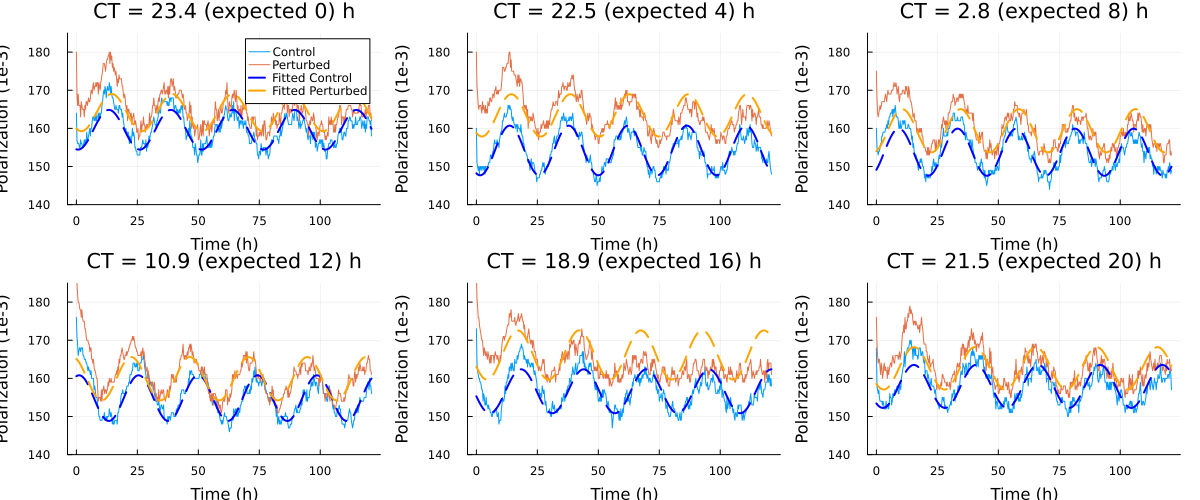

Dict{Int64, Float64} with 6 entries:
  0  => -1.40505
  4  => -0.735917
  16 => 0.992002
  20 => -0.382432
  12 => 2.72552
  8  => -1.4476

In [6]:
p_vec = []

p0 = [24., 0., 10., 160.]
lb = [0., -π, 3., 0.]
ub = [100., π, 100., 200.]

start = 12.

fitted_ϕ₀ = Dict()
fitted_ϕp = Dict()

for CT in sort(unique(df_l[!, :CT]))
        tmp = df_l[df_l.CT .== CT, :]
        tmp_fit_c = tmp[tmp.Treatment .== :Control .&& tmp.Time_h .> start, :]
        if CT != 16
            tmp_fit_p = @. tmp[tmp.Treatment == :Perturbed && tmp.Time_h > start, :]
        else
            tmp_fit_p = @. tmp[tmp.Treatment == :Perturbed && tmp.Time_h > start && tmp.Time_h < 60., :]
        end
    
        fit_c = curve_fit(model, tmp_fit_c.Time_h, tmp_fit_c.FP, p0;
                        lower = lb, upper = ub)
        ϕ₀ = coef(fit_c)[2]
        ϕ₀ = ϕ₀ < 0 ? ϕ₀ + 2π : ϕ₀
        fitted_ϕ₀[CT] = ϕ₀*24/2π
        
        fit_p = curve_fit(model, tmp_fit_p.Time_h, tmp_fit_p.FP, p0;
                        lower = lb, upper = ub)
        ϕp = coef(fit_p)[2]
        ϕp = ϕp < 0 ? ϕp + 2π : ϕp
        fitted_ϕp[CT] = ϕp*24/2π
        
        p = plot(tmp[tmp[!, :Treatment] .== :Control, :Time_h],
            tmp[tmp[!, :Treatment] .== :Control, :FP], 
            label="Control", title=(@sprintf "CT = %.1f (expected %i) h" fitted_ϕ₀[CT] CT),
            xlabel="Time (h)", ylabel="Polarization (1e-3)",
            ylim=(140, 185), legend=CT==0)
        plot!(tmp[tmp[!, :Treatment] .== :Perturbed, :Time_h],
                tmp[tmp[!, :Treatment] .== :Perturbed, :FP], label="Perturbed")
        
        # fitted curve
        t_vec = 0:0.1:maximum(tmp_fit_c.Time_h)
        plot!(t_vec, model(t_vec, coef(fit_c)), style=:dash, width=2, label="Fitted Control", color=:blue)
        plot!(t_vec, model(t_vec, coef(fit_p)), style=:dash, width=2, label="Fitted Perturbed", color=:orange)
        p_vec = [p_vec; p]
end
pp = plot(p_vec..., layout=(2, 3), 
        size=(1200, 500), margin=3Plots.mm, fmt=:png)
display(pp)

Δϕ_dict = Dict(CT => fitted_ϕp[CT] - ϕ₀ for (CT, ϕ₀) in fitted_ϕ₀)
Δϕ_dict = Dict(CT => Δϕ > 12 ? Δϕ - 24 : Δϕ for (CT, Δϕ) in Δϕ_dict)

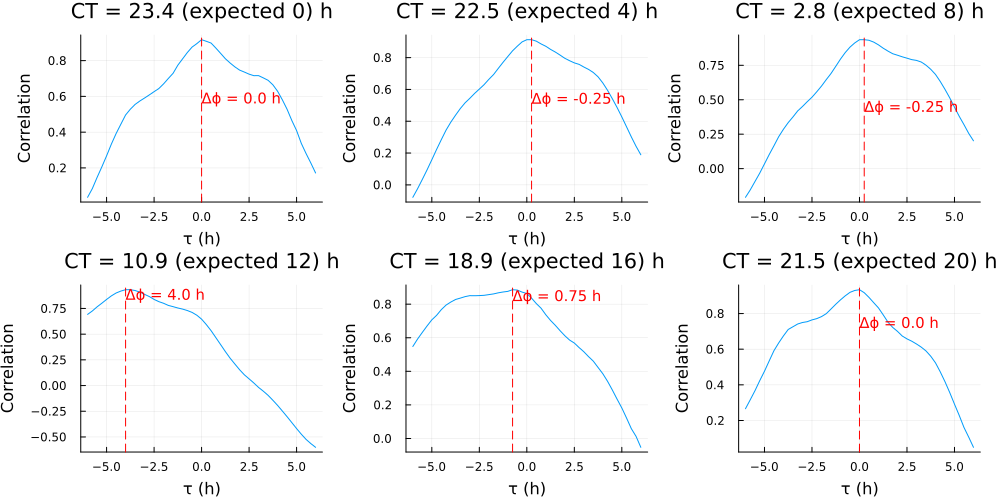

In [7]:
p_vec = []

Δϕ_dict2 = Dict()

for CT in sort(unique(df_l[!, :CT]))
    p = plot(-6:0.25:6, corr_dict[CT], 
            title=(@sprintf "CT = %.1f (expected %i) h" fitted_ϕ₀[CT] CT), 
            legend=false, xlabel="τ (h)", ylabel="Correlation")
    imax = argmax((i -> corr_dict[CT][i]), 1:length(corr_dict[CT]))
    Δϕ = (imax - 25)*0.25
    Δϕ_dict2[CT] = abs(Δϕ) < 1e-6 ? 0. : -Δϕ
    vline!([Δϕ], c=:red, style=:dash)
    annotate!(Δϕ, corr_dict[CT][13],
            text("Δϕ = $(Δϕ_dict2[CT]) h", :left, :red, 10))
    p_vec = [p_vec; p]
end

pp = plot(p_vec..., layout=(2, 3), 
        size=(1000, 500), margin=3Plots.mm, fmt=:png)
display(pp)

Get control phase by time correlation

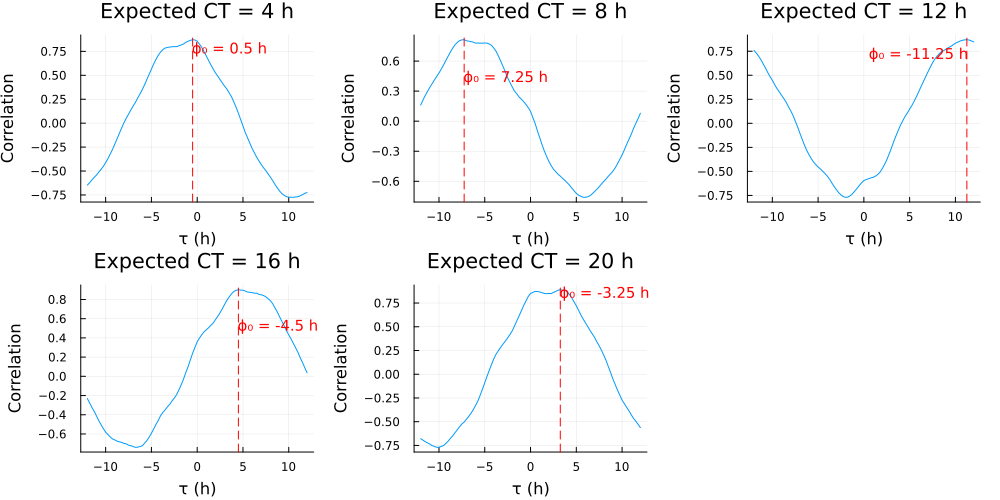

In [11]:
# calculate correlations between controls
corr_ctrl = Dict()

for CT in unique(df_l[!, :CT])
    if CT == 0
        continue
    end
    
    corr_vec = []
    for i in -48:48    # up to 12 hours
        r = corr(i, df_l[df_l.CT .== 0 .&& df_l.Treatment .== :Control .&& df_l.Time_h .> 12., :FP],
                    df_l[df_l.CT .== CT .&& df_l.Treatment .== :Control .&& df_l.Time_h .> 12., :FP])
        corr_vec = [corr_vec; r]
    end
    corr_ctrl[CT] = corr_vec
end

# plot and extract the maximum
p_vec = []

fitted_ϕ₀2 = Dict()
fitted_ϕ₀2[0] = 0    # arbitrarily chosen

for CT in sort(unique(df_l[!, :CT]))
    if CT == 0
        continue
    end

    p = plot(-12:0.25:12, corr_ctrl[CT],
            title=(@sprintf "Expected CT = %i h" CT), 
            legend=false, xlabel="τ (h)", ylabel="Correlation")
    imax = argmax((i -> corr_ctrl[CT][i]), 1:length(corr_ctrl[CT]))
    Δϕ = (imax - 49)*0.25
    fitted_ϕ₀2[CT] = Δϕ > 0 ? -Δϕ + 24 : -Δϕ
    vline!([Δϕ], c=:red, style=:dash)
    annotate!(Δϕ, corr_ctrl[CT][imax - 12],
            text("ϕ₀ = $(-Δϕ) h", CT == 12 ? :right : :left, :red, 10))
    p_vec = [p_vec; p]
end

pp = plot(p_vec..., layout=(2, 3), 
        size=(1000, 500), margin=3Plots.mm, fmt=:png)
display(pp)

In [12]:
# adding a baseline to ϕ₀ fit using time correlation
CT_vec = 0:4:20
fitted_ϕ₀2 = Dict(CT => mod(fitted_ϕ₀2[CT] + fitted_ϕ₀[0], 24) for CT in CT_vec)

Dict{Int64, Float64} with 6 entries:
  0  => 23.3767
  4  => 23.8767
  16 => 18.8767
  20 => 20.1267
  12 => 12.1267
  8  => 6.62666

Visualize in the ring space

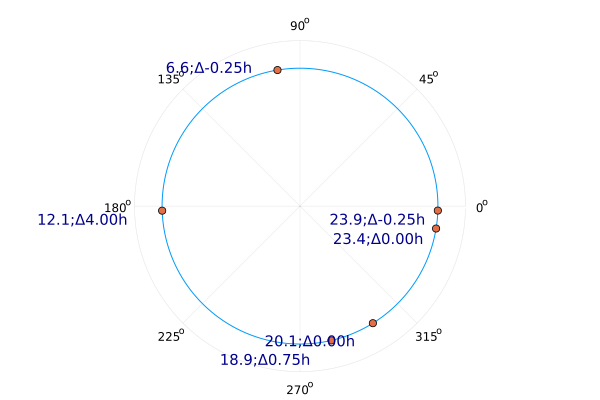

In [13]:
θ_vec = 0:0.01:2π
pp = plot(θ_vec, ones(length(θ_vec)), proj=:polar, ylim=(0, 1.2), legend=false, fmt=:png, yticks=false)

CT_vec = 0:4:20
scatter!(([fitted_ϕ₀2[CT] for CT in CT_vec])/24*2π, ones(length(CT_vec)))

for CT in CT_vec
    plot!([0.], [0.], 
        annotations=(cos(fitted_ϕ₀2[CT]/24*2π)*0.9 - 0.15,    # shift for aesthetics 
                    sin(fitted_ϕ₀2[CT]/24*2π)*0.9 - 0.05,
                    text((@sprintf "%.1f;Δ%.2fh" fitted_ϕ₀2[CT] Δϕ_dict2[CT]), :darkblue, :right, 10)))
end
    
display(pp)

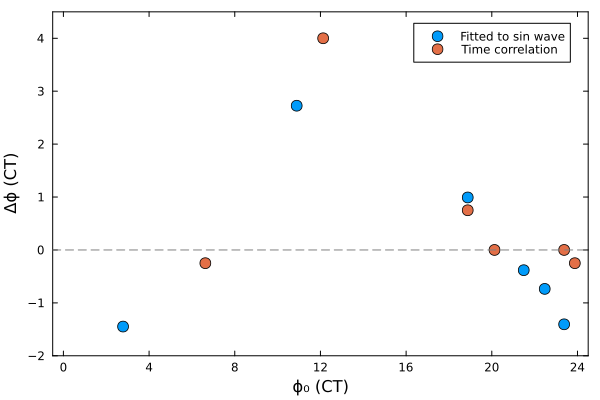

In [14]:
pp = scatter([fitted_ϕ₀[CT] for CT in CT_vec],
    [Δϕ_dict[CT] for CT in CT_vec],
    markersize=6, xlabel="ϕ₀ (CT)", ylabel="Δϕ (CT)", 
    xlim=(-0.5, 24.5), xticks=0:4:24, ylim = (-2, 4.5), 
    frame=:box, grid=false, label="Fitted to sin wave", fmt=:png)

scatter!([fitted_ϕ₀2[CT] for CT in CT_vec],
        [Δϕ_dict2[CT] for CT in CT_vec],
        markersize = 6, label="Time correlation")

hline!([0.], style=:dash, color=:gray, label=:none, z=-2)

Fit PRC to continuous functions

$$
\Delta\phi(\phi_0)/\text{CT} = A_0 + A_1\cos(\phi_0 - \psi_1) + A_2\cos(2\phi_0 - \psi_2)
$$

In [15]:
function prc_model(ϕ₀, p)
    A0, A1, ψ1, A2, ψ2 = p
    @. A0 + A1*cos(ϕ₀ - ψ1) + A2*cos(2ϕ₀ - ψ2)
end

prc_model (generic function with 1 method)

Fitted
A₀ = 0.77
A₁ = 2.07
ψ₁ = 3.24
A₂ = 0.59
ψ₂ = 4.21
Time correlation
A₀ = 1.18
A₁ = 2.22
ψ₁ = 3.56
A₂ = 0.91
ψ₂ = 0.64


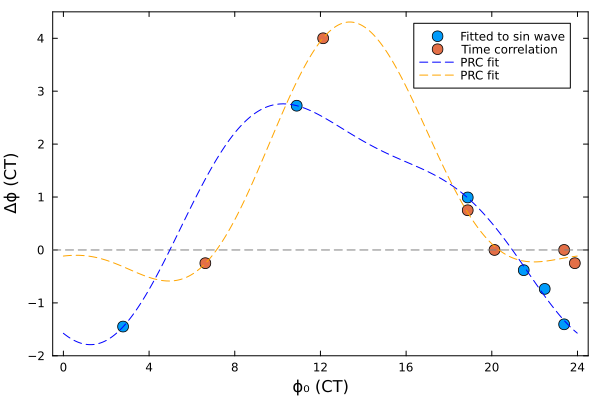

In [16]:
# initial parameters
p0 = [0.1, 2., π, 2., π]
lb = [0., 0., 0., 0., 0.]
ub = [10., 10., 2π, 10., 2π]
name_vec = ["A₀", "A₁", "ψ₁", "A₂", "ψ₂"]

fit_fit = curve_fit(prc_model, [fitted_ϕ₀[CT]/24*2π for CT in CT_vec],
                    [Δϕ_dict[CT] for CT in CT_vec], p0;
                    lower=lb, upper=ub)
println("Fitted")
for i in 1:length(name_vec)
    println(name_vec[i]*(@sprintf " = %.2f" coef(fit_fit)[i]))
end

ϕ_span = 0:0.01:2π
plot!(pp, ϕ_span/(2π)*24, prc_model(ϕ_span, coef(fit_fit)),
    color=:blue, style=:dash, label="PRC fit")
    
fit_corr = curve_fit(prc_model, [fitted_ϕ₀2[CT]/24*2π for CT in CT_vec],
                    [Δϕ_dict2[CT] for CT in CT_vec], p0;
                    lower=lb, upper=ub)
println("Time correlation")
for i in 1:length(name_vec)
    println(name_vec[i]*(@sprintf " = %.2f" coef(fit_corr)[i]))
end

ϕ_span = 0:0.01:2π
plot!(pp, ϕ_span/(2π)*24, prc_model(ϕ_span, coef(fit_corr)),
    color=:orange, style=:dash, label="PRC fit")

Fitted
A₀ = 0.77
A₁ = 2.07
ψ₁ = 3.24
A₂ = 0.59
ψ₂ = 4.21


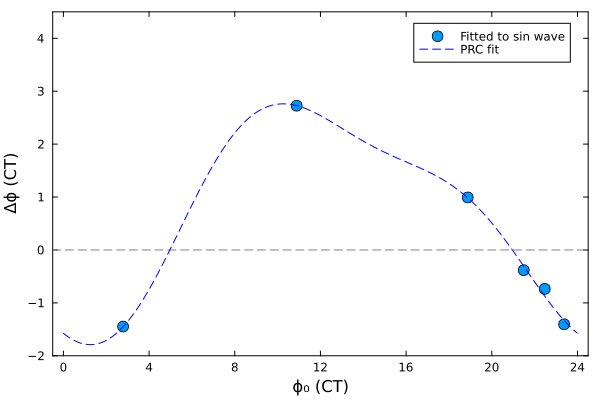

In [19]:
# initial parameters
p0 = [0.1, 2., π, 2., π]
lb = [0., 0., 0., 0., 0.]
ub = [10., 10., 2π, 10., 2π]
name_vec = ["A₀", "A₁", "ψ₁", "A₂", "ψ₂"]

pp = scatter([fitted_ϕ₀[CT] for CT in CT_vec],
    [Δϕ_dict[CT] for CT in CT_vec],
    markersize=6, xlabel="ϕ₀ (CT)", ylabel="Δϕ (CT)", 
    xlim=(-0.5, 24.5), xticks=0:4:24, ylim = (-2, 4.5), 
    frame=:box, grid=false, label="Fitted to sin wave", fmt=:png)

# scatter!([fitted_ϕ₀2[CT] for CT in CT_vec],
#         [Δϕ_dict2[CT] for CT in CT_vec],
#         markersize = 6, label="Time correlation")

hline!([0.], style=:dash, color=:gray, label=:none, z=-2)

fit_fit = curve_fit(prc_model, [fitted_ϕ₀[CT]/24*2π for CT in CT_vec],
                    [Δϕ_dict[CT] for CT in CT_vec], p0;
                    lower=lb, upper=ub)
println("Fitted")
for i in 1:length(name_vec)
    println(name_vec[i]*(@sprintf " = %.2f" coef(fit_fit)[i]))
end

ϕ_span = 0:0.01:2π
plot!(pp, ϕ_span/(2π)*24, prc_model(ϕ_span, coef(fit_fit)),
    color=:blue, style=:dash, label="PRC fit")
    
# fit_corr = curve_fit(prc_model, [fitted_ϕ₀2[CT]/24*2π for CT in CT_vec],
#                     [Δϕ_dict2[CT] for CT in CT_vec], p0;
#                     lower=lb, upper=ub)
# println("Time correlation")
# for i in 1:length(name_vec)
#     println(name_vec[i]*(@sprintf " = %.2f" coef(fit_corr)[i]))
# end

# ϕ_span = 0:0.01:2π
# plot!(pp, ϕ_span/(2π)*24, prc_model(ϕ_span, coef(fit_corr)),
#     color=:orange, style=:dash, label="PRC fit")

$$
\frac{d}{dt}\theta = \omega + rf(\theta)\\
T = \int_0^T dt = \int_0^{2\pi} \frac{d\theta}{\omega + rf(\theta)}
$$

Where $\omega$ is the intrinsic angular velocity, $r$ is the growth rate, and $f(\theta)$ is the growth response function

The period change is perdicted to be

$$
T - T_0 = \left(\int_0^{2\pi}\frac{d\theta}{\omega + k \text{PRC}(\theta)}\right) - \frac{2\pi}{\omega}
$$

Save estimated $\Delta\phi$ v.s. $\phi_0$

In [14]:
import DataFrames, CSV

In [15]:
df = DataFrame(Expected_ϕ₀_CT = [CT_vec; CT_vec],
            Estimated_ϕ₀_CT = [[fitted_ϕ₀[CT] for CT in CT_vec]; [fitted_ϕ₀2[CT] for CT in CT_vec]],
            Δϕ_CT = [[Δϕ_dict[CT] for CT in CT_vec]; [Δϕ_dict2[CT] for CT in CT_vec]],
            Method = [repeat(["Fitting_sin"], length(CT_vec)); repeat(["Time_corr"], length(CT_vec))])

Row,Expected_ϕ₀_CT,Estimated_ϕ₀_CT,Δϕ_CT,Method
,Int64,Real,Float64,String
1,0,23.3767,-1.40505,Fitting_sin
2,4,22.471,-0.735917,Fitting_sin
3,8,2.78553,-1.4476,Fitting_sin
4,12,10.8919,2.72552,Fitting_sin
5,16,18.877,0.992002,Fitting_sin
6,20,21.4913,-0.382432,Fitting_sin
7,0,0,0.0,Time_corr
8,4,0.5,-0.25,Time_corr
9,8,7.25,-0.25,Time_corr


In [16]:
# CSV.write("outputs/estimated_phi0_Deltaphi.csv", df)